# U-2-NETp STEP-BY-STEP DEMONSTRATION

**Using U-2-NETp for :**
 - **Background Removal**
 - **Bounding Box Creation**
 - **Salient Feature Highlighting**


 U-2-NET Paper: [U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/abs/2005.09007)

 Original Repo: [U-2-Net Github repo](https://github.com/NathanUA/U-2-Net)

References: X. Qin, Z. Zhang, C. Huang, M. Dehghan, O. R. Zaiane, and M. Jagersand, “U2-net: Going deeper with nested u-structure for salient object
detection,” Pattern Recognition, vol. 106, p. 107404, 2020

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# make sure cloned code is saved in content
%cd /content/drive/MyDrive/SALIENT_DETECTION
# verify CUDA
#!/usr/local/cuda/bin/nvcc --version
# clone modified version of U-2-Net
#!git clone https://github.com/shreyas-bk/U-2-Net

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/18O3OFm4e2jwcgq9rhsVxScRGX3faofYU/SALIENT_DETECTION


In [2]:
# make images directory (to store imput images) and results (to store output images) in U-2-Net folder
%cd /content/drive/MyDrive/SALIENT_DETECTION/U-2-Net

from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
from skimage.transform import resize

/content/drive/.shortcut-targets-by-id/18O3OFm4e2jwcgq9rhsVxScRGX3faofYU/SALIENT_DETECTION/U-2-Net


In [72]:
# run the test script, and outputs are saved to results folder
#!python -W ignore u2net_test.py
import os
from skimage import io, transform
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms#, utils
# import torch.optim as optim

import numpy as np
from PIL import Image
import glob

from data_loader import RescaleT
from data_loader import ToTensor
from data_loader import ToTensorLab
from data_loader import SalObjDataset

from model import U2NET # full size version 173.6 MB
from model import U2NETP # small version u2net 4.7 MB
import matplotlib.pyplot as plt

filename = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/ResizedImgs/16.jpg"
filebackgrounds = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/Backgrounds/03.jpg"

ImgFolder = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/ResizedImgs"
Marks = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/Marks/"
Backgrounds = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/Backgrounds"
RemoveBackgrounds = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/RemoveBackgrounds/"
AddedBackground = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/AddedBackground/"
Models = "/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/u2netp.pth"

img_name = filename.split(os.sep)[-1]
nameimg = "Mask"+img_name.split(".")[0] + ".png"

# Make sure runtype is GPU
**Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU**

['/content/drive/MyDrive/SALIENT_DETECTION/U-2-Net/ResizedImgs/16.jpg']
inferencing: 16.jpg


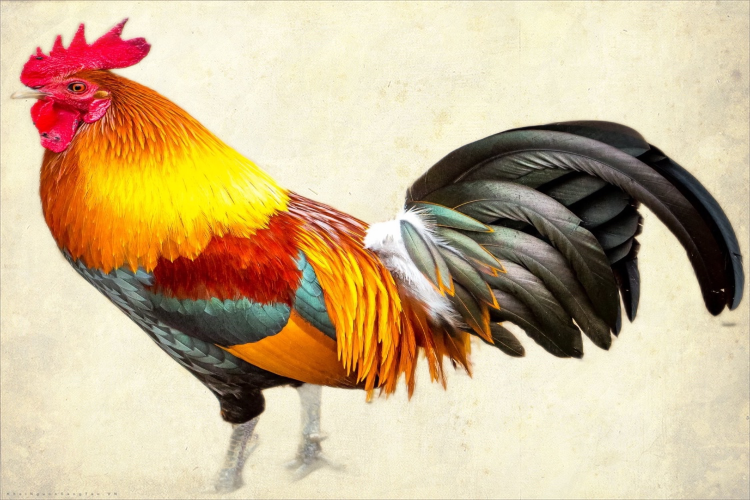

In [73]:
# normalize the predicted SOD probability map
def normPRED(d):
    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)

    return dn

def save_output(pred):

    predict = pred
    predict = predict.squeeze()
    predict_np = predict.cpu().data.numpy()
    im = Image.fromarray(predict_np*255).convert('RGB')
    image = io.imread(filename)
    imo = im.resize((image.shape[1],image.shape[0]),resample=Image.BILINEAR)
    pb_np = np.array(imo)
    imo.save(Marks + nameimg)

def main(filename):

    # --------- 1. get image path and name ---------
    model_name='u2netp'
    prediction_dir = Marks
    model_dir = Models

    img_name_list = []
    img_name_list.append(filename)
    print(img_name_list)

    # --------- 2. dataloader ---------
    #1. dataloader
    test_salobj_dataset = SalObjDataset(img_name_list = img_name_list,
                                        lbl_name_list = [],
                                        transform=transforms.Compose([RescaleT(320),
                                                                      ToTensorLab(flag=0)])
                                        )
    test_salobj_dataloader = DataLoader(test_salobj_dataset,
                                        batch_size=1,
                                        shuffle=False,
                                        num_workers=1)

    # --------- 3. model define ---------
    net = U2NETP(3,1)    
    if torch.cuda.is_available():
        net.load_state_dict(torch.load(model_dir))
        net.cuda()
    else:        
        net.load_state_dict(torch.load(model_dir, map_location=torch.device('cpu')))

    net.eval()

    # --------- 4. inference for each image ---------
    for i_test, data_test in enumerate(test_salobj_dataloader):

        print("inferencing:",img_name_list[i_test].split(os.sep)[-1])

        inputs_test = data_test['image']
        inputs_test = inputs_test.type(torch.FloatTensor)

        if torch.cuda.is_available():
            inputs_test = Variable(inputs_test.cuda())
        else:
            inputs_test = Variable(inputs_test)

        d1,d2,d3,d4,d5,d6,d7= net(inputs_test)

        # normalization
        pred = d1[:,0,:,:]
        pred = normPRED(pred)
        save_output(pred)

        del d1,d2,d3,d4,d5,d6,d7

main(filename)

# display result that U-2-Net created
output = load_img(Marks + nameimg)

# convert output to numpy array and rescale(255 for RBG images)
RESCALE = 255
out_img = img_to_array(output)
out_img /= RESCALE


# convert the rbg image to an rgba image and set the zero values to transparent
shape = out_img.shape
a_layer_init = np.ones(shape = (shape[0],shape[1],1))
mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
a_layer = mul_layer*a_layer_init
rgba_out = np.append(out_img,a_layer,axis=2)

# load and convert input to numpy array and rescale(255 for RBG images)
input = load_img(filename)
inp_img = img_to_array(input)
inp_img /= RESCALE

# since the output image is rgba, convert this also to rgba, but with no transparency
a_layer = np.ones(shape = (shape[0],shape[1],1))
rgba_inp = np.append(inp_img,a_layer,axis=2)

# simply multiply the 2 rgba images to remove the backgound
rem_back = (rgba_inp*rgba_out)
rem_back_scaled = Img.fromarray((rem_back*RESCALE).astype('uint8'), 'RGBA')

# save the resulting image to colab
rem_back_scaled.save(RemoveBackgrounds +"background_removed"+ nameimg)


# load and convert background to numpy array and rescale(255 for RBG images)
background_input = load_img(filebackgrounds)
background_inp_img = img_to_array(background_input)
background_inp_img /= RESCALE

# get dimensions of background (original image will be resized to dimensions of background image in this notebook)
background_height = background_inp_img.shape[0]
background_width = background_inp_img.shape[1]
background_height,background_width

# resize the image
resized_rem_back  = resize(rem_back, (background_height,background_width))

# create a new array which will store the final result
output_chbg = np.zeros((background_height, background_width, 3))

# using the following o[c] = b[c]*(1-i[t])+i[c] {where o - output image, c - channels from 1-3, i - input image with background removed, t - transparent channel}, obtain values for the final result
output_chbg[:,:,0] = background_inp_img[:,:,0]*(1-resized_rem_back[:,:,3])+resized_rem_back[:,:,0]
output_chbg[:,:,1] = background_inp_img[:,:,1]*(1-resized_rem_back[:,:,3])+resized_rem_back[:,:,1]
output_chbg[:,:,2] = background_inp_img[:,:,2]*(1-resized_rem_back[:,:,3])+resized_rem_back[:,:,2]

# rescale
output_chbg_scaled = Img.fromarray((output_chbg*RESCALE).astype('uint8'), 'RGB')
# save the resulting image to colab
output_chbg_scaled.save(AddedBackground+"addedbackgrounds" + nameimg)
#display(output_chbg_scaled)